In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../src')

import numpy as np
# from utils import adata_train
import scanpy as sc 
adata_train = sc.read_h5ad('/ix/djishnu/alw399/SpaceOracle/notebooks/.cache/adata_train.h5ad')

In [4]:
from tqdm import tqdm
import pandas as pd

import celloracle as co
oracle = co.data.load_tutorial_oracle_object()

which: no R in (/ix/djishnu/alw399/envs/bee/bin:/ix/djishnu/alw399/envs/bee/bin:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/condabin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/lib/vscode/bin/remote-cli:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/bin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/bin:/ihome/crc/install/git/2.33.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/b

In [4]:
import spaceoracle

# dummy params bc we don't use it

so = spaceoracle.SpaceOracle(
    adata=adata_train,
    annot='rctd_cluster', 
    max_epochs=1, 
    learning_rate=7e-4, 
    spatial_dim=1,
    batch_size=256,
    init_betas='zeros',
    rotate_maps=True,
    cluster_grn=True,
    regularize=True,
)


🌍️ Generating spatial 1x1 maps...


In [5]:
import copy 

so.adata = copy.deepcopy(oracle.adata)
so.pcs, so.pca = so.perform_PCA(so.adata)
so.knn_imputation(so.adata, so.pcs)
so.gene2index = dict(zip(
                so.adata.var_names, 
                range(len(so.adata.var_names))
            ))


In [6]:
so.embedding_name = 'X_draw_graph_fa'
so.embedding = so.adata.obsm['X_draw_graph_fa']
so.cluster_column_name = 'louvain'

In [7]:
from celloracle.applications import Pseudotime_calculator

pt = Pseudotime_calculator(oracle_object=so)

In [8]:
# Instantiate pseudotime object using anndata object.
pt = Pseudotime_calculator(adata=so.adata,
                           obsm_key=so.embedding_name, # Dimensional reduction data name
                           cluster_column_name=so.cluster_column_name # Clustering data name
                           )

45


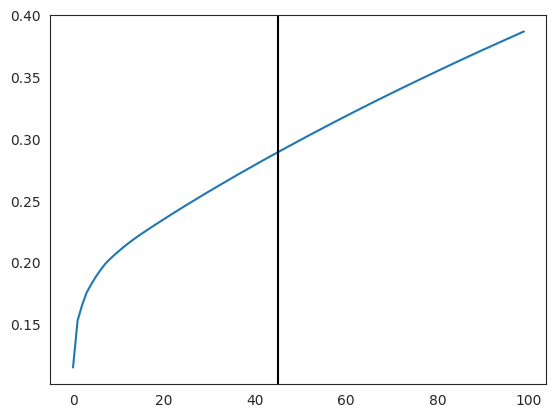

In [9]:
# Select important PCs
%matplotlib inline
import matplotlib.pyplot as plt
import scanpy as sc 

plt.plot(np.cumsum(so.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(so.pca.explained_variance_ratio_))>0.002))[0][0]
print(n_comps)

plt.axvline(n_comps, c="k")
plt.show()
n_comps = min(n_comps, 50)

In [10]:
n_cell = so.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :2671
Auto-selected k is :66


In [11]:
so.knn_imputation(so.adata, so.pcs, n_pca_dims=n_comps, k=k, balanced=False, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

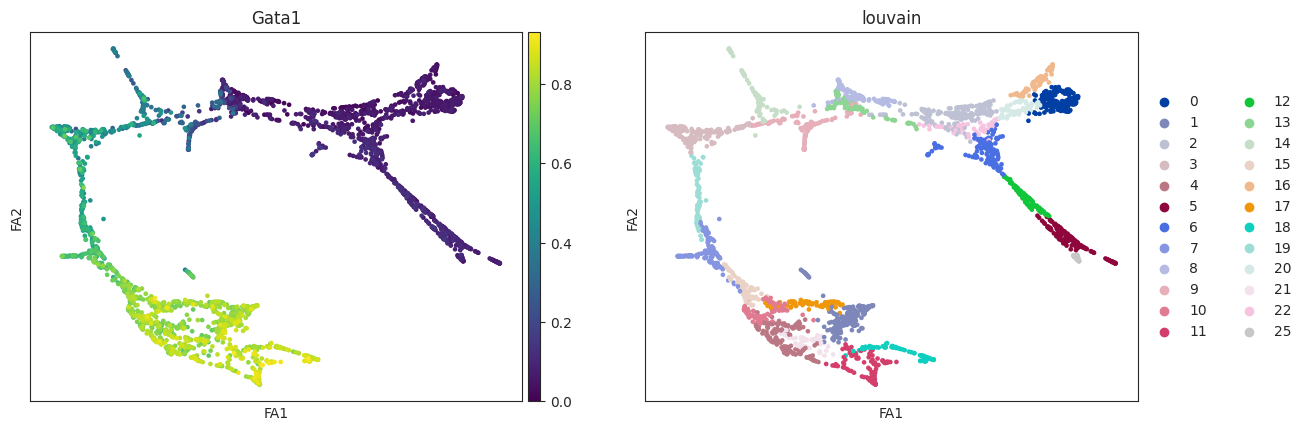

In [12]:
# Check gene expression 
import scanpy as sc 

goi = "Gata1"
sc.pl.draw_graph(so.adata, color=[goi, so.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

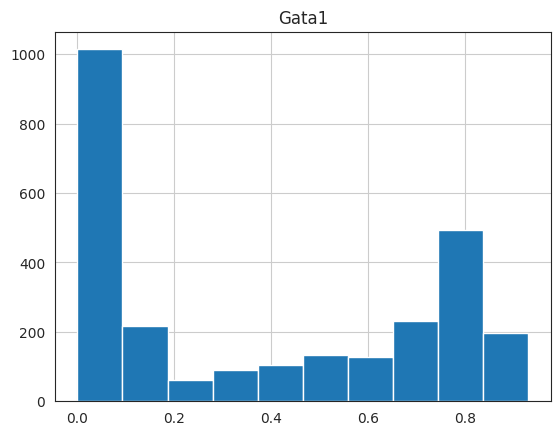

In [13]:
# Plot gene expression in histogram
sc.get.obs_df(so.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [14]:
# need cell oracle coef_matrix

links = co.data.load_tutorial_links_object()
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/24 [00:00<?, ?it/s]

In [15]:
# Construct coef for each cell (gene x gene x cell)
betas_dict = {}

for i, cell_cluster in enumerate(list(so.adata.obs['louvain_annot'])):
    cell_coef = oracle.coef_matrix_per_cluster[cell_cluster]
    betas_dict[i] = cell_coef
    
len(betas_dict)

2671

In [ ]:
oracle.coef_matrix_per_cluster

In [16]:
so.co_beta_dict = oracle.coef_matrix_per_cluster

In [17]:
so.simulate_co_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

Running simulation 3/3: 100%|██████████| 2671/2671 [02:38<00:00, 16.81it/s]


In [18]:
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [19]:
np.allclose(oracle.adata.layers['delta_X'], so.adata.layers['delta_X'], rtol=0.001, atol=0.1)

True

In [20]:
# oracle.adata.layers['delta_X'], so.adata.layers['delta_X']

In [21]:
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

In [22]:
so.estimate_transition_prob(n_neighbors=200,
                                knn_random=True, 
                                sampled_fraction=1)

so.calculate_embedding_shift(sigma_corr=0.05)

In [23]:
# np.allclose(oracle.embedding, so.embedding)
# np.allclose(so.embedding_knn.toarray(), oracle.embedding_knn.toarray())
# np.allclose(oracle.sampling_ixs, so.sampling_ixs)
# np.allclose(oracle.corrcoef, so.corrcoef, rtol=0.001, atol=0.1)
# np.allclose(oracle.transition_prob, so.transition_prob, rtol=0.001, atol=0.1)
# np.allclose(oracle.delta_embedding, so.delta_embedding, rtol=0.001, atol=0.1)

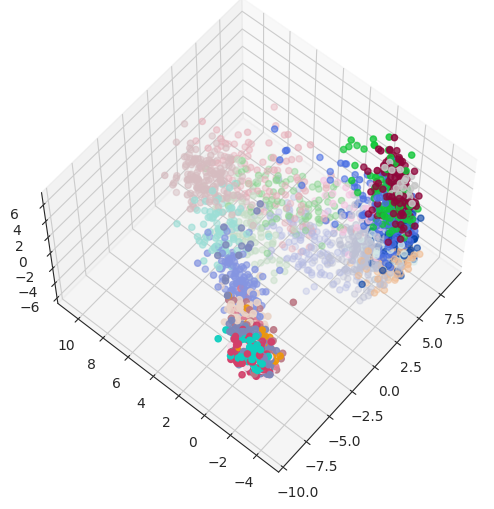

In [24]:
so.plot_pca()

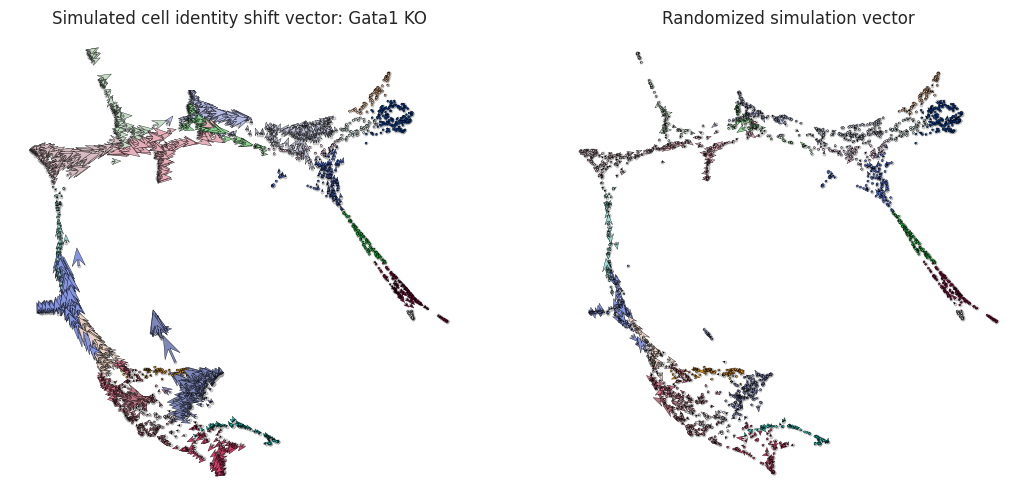

In [25]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
so.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [26]:
# n_grid = 40 is a good starting value.
n_grid = 40 
so.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

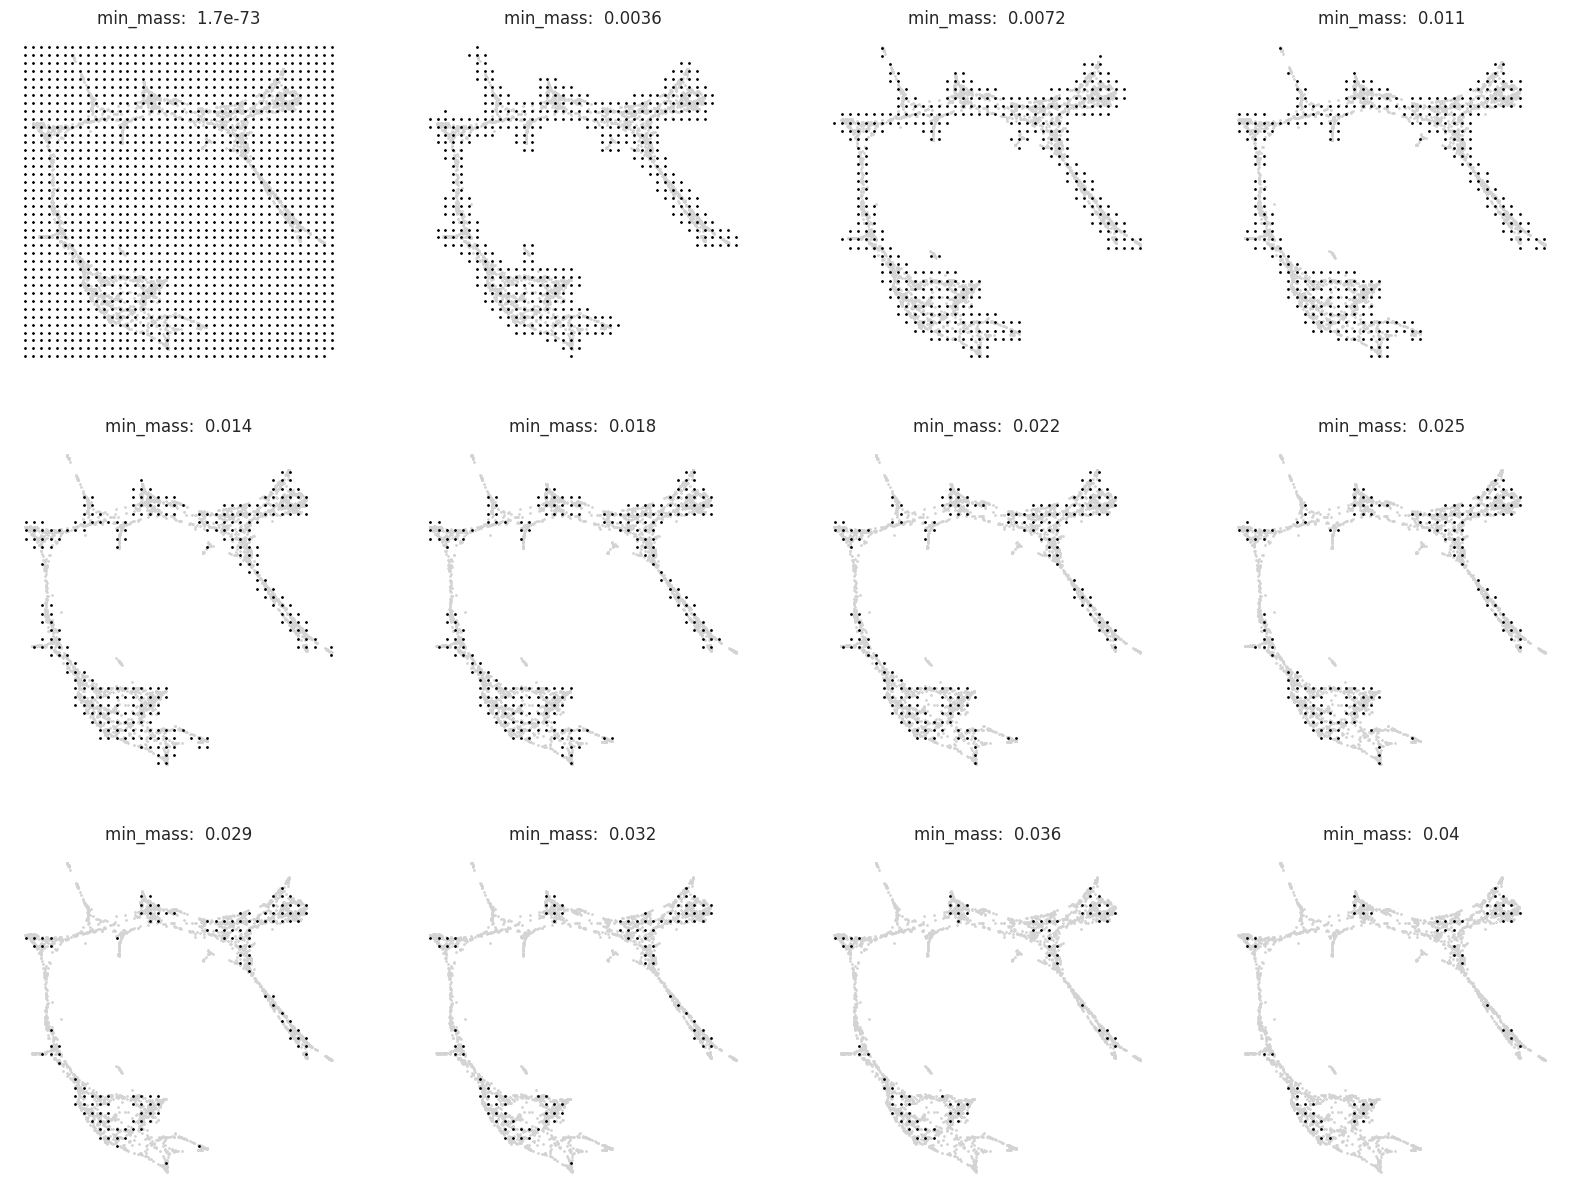

In [27]:
# Search for best min_mass.
so.suggest_mass_thresholds(n_suggestion=12)

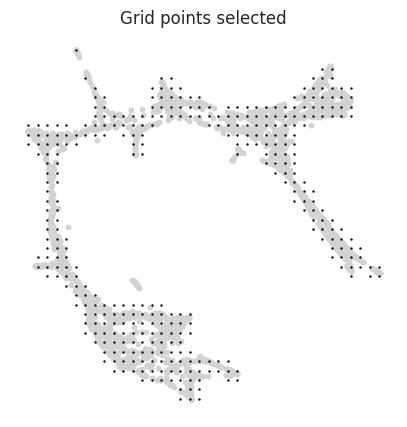

In [28]:
min_mass = 0.01
so.calculate_mass_filter(min_mass=min_mass, plot=True)

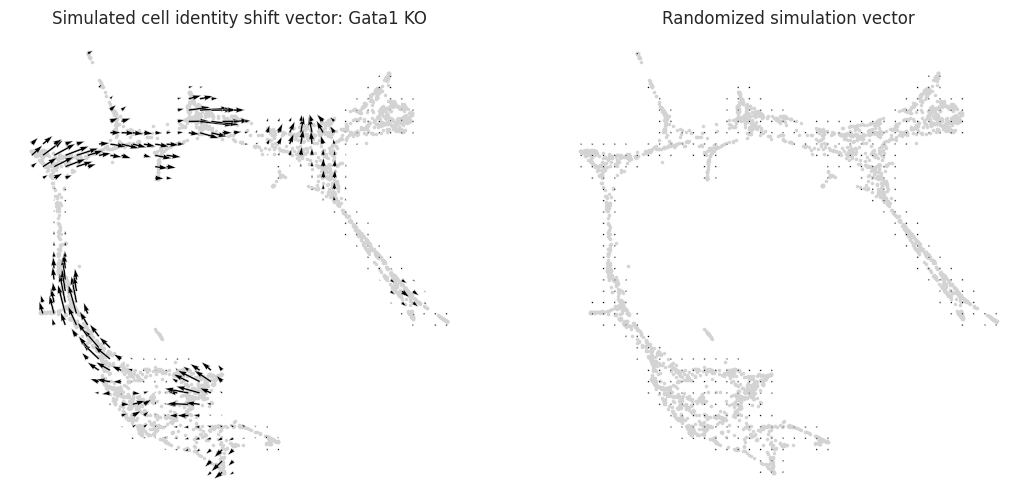

In [29]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 0.5
# Show quiver plot
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

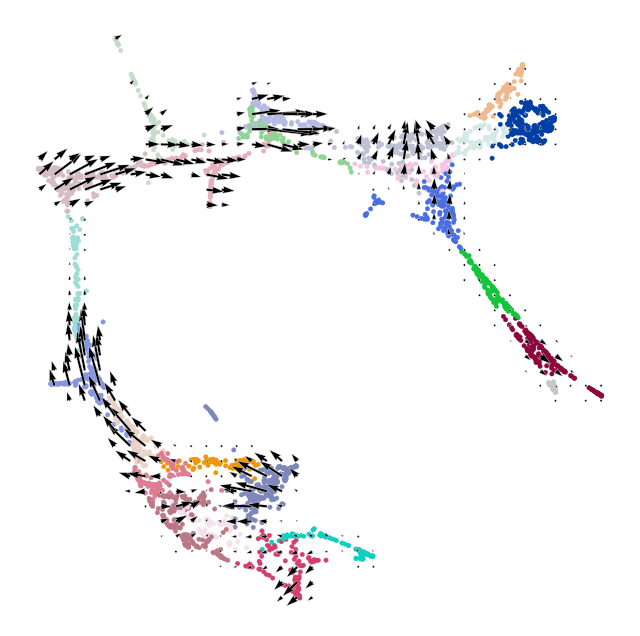

In [30]:
# Plot vector field with cell cluster 
fig, ax = plt.subplots(figsize=[8, 8])

so.plot_cluster_whole(ax=ax, s=10)
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)